In [1]:
import os
from contextlib import contextmanager, nullcontext

from ax.utils.testing.mock import fast_botorch_optimize_context_manager
import plotly.io as pio

# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

NUM_EVALS = 100

In [2]:
from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor

In [3]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from botorch.models.gp_regression import SingleTaskGP
from ax.models.torch.botorch_modular.surrogate import Surrogate

In [4]:
SingleTaskGP

botorch.models.gp_regression.SingleTaskGP

In [5]:
from botorch.acquisition.analytic import ExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement

In [6]:
ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SingleTaskGP,
        # Optional, MLL class with which to optimize model parameters
        mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    botorch_acqf_class=qExpectedImprovement,
)

In [7]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models

In [8]:
gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=40,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
            },
        ),
    ]
)

In [9]:
gs

GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 40 trials, BoTorch for subsequent trials])

In [10]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Ackley

In [11]:
dim = 20
parameters = [
    {
        "name": f"x{i + 1}",
        "type": "range",
        "bounds": [-5.0, 10.0], 
        "value_type": "float"
    }
    for i in range(0, dim)
]

In [12]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="ackley_test_experiment",
    parameters=parameters, 
    objectives={
        "ackley": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
ackley = Ackley(dim=dim) 

[INFO 01-08 00:15:45] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 01-08 00:15:45] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x3', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x4', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x5', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x6', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x7', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x8', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x9', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x10', parameter_type=FLOAT, range=[

In [19]:
import numpy as np
x = np.array([ 1.31264152e-07, 1.66562580e-07, -4.34878109e-08, 9.54600626e-08, -8.31953207e-08, 1.07066753e-08, -2.42526948e-08, 2.16816821e-07, 1.07359898e-07, 6.65759900e-08, -1.88540814e-07 -2.30301548e-07, -3.23500616e-08 -7.95021209e-08, 1.02570316e-07 -2.21574422e-08, 9.40786391e-08, 7.78418562e-08, 8.69167474e-09, -1.52812974e-08])
x = torch.from_numpy(x)

ackley(x)

tensor(5.1861e-07, dtype=torch.float64)

In [13]:
def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(dim)]])
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    return {"ackley": (ackley(x).item(), float("nan"))}

In [14]:
torch.manual_seed(0)

In [15]:
for i in range(NUM_EVALS):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 01-05 17:36:08] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.62583, 'x2': 9.359564, 'x3': 0.684446, 'x4': 3.330821, 'x5': 9.512373, 'x6': 7.744905, 'x7': 4.242757, 'x8': 2.73678, 'x9': 1.892736, 'x10': 3.896934, 'x11': -0.16574, 'x12': 4.1864, 'x13': 6.189902, 'x14': 1.920653, 'x15': -4.790502, 'x16': -4.06626, 'x17': 7.118045, 'x18': 7.088239, 'x19': 5.346537, 'x20': -1.727022}.
[INFO 01-05 17:36:08] ax.service.ax_client: Completed trial 0 with data: {'ackley': (14.414439, nan)}.
[INFO 01-05 17:36:08] ax.service.ax_client: Generated new trial 1 with parameters {'x1': -0.334607, 'x2': 8.292279, 'x3': -0.804496, 'x4': 5.508129, 'x5': 6.856611, 'x6': 2.30934, 'x7': -3.231775, 'x8': -2.325992, 'x9': 8.410276, 'x10': -0.809668, 'x11': 0.726441, 'x12': 6.423683, 'x13': 0.071553, 'x14': 0.741447, 'x15': 5.027757, 'x16': 8.427327, 'x17': 7.991047, 'x18': 1.853681, 'x19': 8.293869, 'x20': -0.101173}.
[INFO 01-05 17:36:08] ax.service.ax_client: Completed trial 1 wi

In [16]:
ax_client.get_trials_data_frame()

[WARNING 01-05 17:38:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,ackley,x1,x2,x3,x4,x5,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
0,0,0_0,COMPLETED,Sobol,14.414439,0.625830,9.359564,0.684446,3.330821,9.512373,...,-0.165740,4.186400,6.189902,1.920653,-4.790502,-4.066260,7.118045,7.088239,5.346537,-1.727022
1,1,1_0,COMPLETED,Sobol,14.461775,-0.334607,8.292279,-0.804496,5.508129,6.856611,...,0.726441,6.423683,0.071553,0.741447,5.027757,8.427327,7.991047,1.853681,8.293869,-0.101173
2,2,2_0,COMPLETED,Sobol,14.401449,5.282910,1.113288,3.464888,1.178461,6.907922,...,1.555224,-2.431571,-2.468861,3.232612,1.248182,8.520169,-3.533012,1.784489,7.004841,-2.527035
3,3,3_0,COMPLETED,Sobol,14.859153,8.762566,5.415087,-3.102796,-3.090601,-3.863515,...,-3.283691,-2.727750,0.194027,4.534835,9.339013,-1.698917,-4.384204,6.413659,2.343597,-3.280323
4,4,4_0,COMPLETED,Sobol,13.925640,7.535781,6.958151,0.169124,6.402701,8.602849,...,3.600424,-4.809199,0.707122,-3.742206,4.645666,1.872030,-2.195936,-4.013613,4.311609,4.284801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95_0,COMPLETED,BoTorch,5.022244,0.870143,-0.398739,0.951081,0.512299,-0.389738,...,0.753887,1.205320,0.170521,0.241342,0.550575,-0.454214,1.210379,0.744514,-1.668186,-0.874198
96,96,96_0,COMPLETED,BoTorch,4.823634,1.163312,0.228837,1.028670,0.366938,-0.118522,...,0.868813,0.962589,-0.546372,0.212699,0.865435,-0.355198,0.594265,0.764083,-1.340228,-0.986548
97,97,97_0,COMPLETED,BoTorch,4.797048,1.212513,0.050739,0.837404,0.341269,-0.158459,...,0.785646,1.064097,-0.224100,0.144116,0.667934,-0.448201,0.823462,0.495965,-1.716846,-0.983922
98,98,98_0,COMPLETED,BoTorch,4.510140,0.981996,-0.045614,0.984485,0.522157,-0.119632,...,0.820635,0.887840,-0.606884,0.159119,0.944659,-0.447005,0.901442,1.033156,-1.436370,-0.917718


In [17]:
frame = ax_client.get_trials_data_frame()
import numpy as np
array = list(np.array(frame['ackley']))

[WARNING 01-05 17:38:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


In [18]:
', '.join(str(x) for x in array)

'14.41443920135498, 14.461774826049805, 14.401449203491211, 14.859152793884277, 13.925640106201172, 15.36014461517334, 14.82453441619873, 12.080455780029297, 13.164048194885254, 14.698695182800293, 15.027447700500488, 12.294116973876953, 12.72812271118164, 14.01265811920166, 14.34798812866211, 14.49909782409668, 14.208045959472656, 14.645901679992676, 14.797473907470703, 14.304415702819824, 15.348946571350098, 13.064675331115723, 12.912101745605469, 13.984400749206543, 11.502269744873047, 13.803656578063965, 14.348960876464844, 15.937365531921387, 13.609556198120117, 13.700654029846191, 13.884244918823242, 14.284223556518555, 15.143747329711914, 14.582493782043457, 15.138199806213379, 13.937830924987793, 15.12769889831543, 15.044733047485352, 12.270512580871582, 13.792906761169434, 10.93890380859375, 11.033723831176758, 10.635937690734863, 10.570703506469727, 10.06364917755127, 9.694433212280273, 9.054372787475586, 8.860556602478027, 8.447493553161621, 8.392316818237305, 8.226993560791

In [57]:
parameters, values = ax_client.get_best_parameters()
print(f"Best parameters: {parameters}")
print(f"Corresponding mean: {values[0]}, covariance: {values[1]}")

Best parameters: {'x1': 1.2371028673186304, 'x2': 1.3821734967092603, 'x3': -0.2980417180826498, 'x4': -0.47804531401737904, 'x5': -0.02685152234933419, 'x6': 1.2498385423946887, 'x7': -0.2502208368385821, 'x8': -0.8583885976935983, 'x9': 1.1897983736168705, 'x10': 0.8627090963639485, 'x11': -0.28795217115097493, 'x12': 1.0798337700988032, 'x13': -1.0642559180944793, 'x14': -0.458687758643495, 'x15': 1.0332283950640004, 'x16': 0.1007341621586475, 'x17': 0.2568321952898245, 'x18': 0.10488260328591892, 'x19': -1.7623762126859859, 'x20': -1.0355933090474965}
Corresponding mean: {'ackley': 4.759496801091742}, covariance: {'ackley': {'ackley': 0.005901710892307955}}


In [58]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters, values[0]

({'x1': 1.2371028673186304,
  'x2': 1.3821734967092603,
  'x3': -0.2980417180826498,
  'x4': -0.47804531401737904,
  'x5': -0.02685152234933419,
  'x6': 1.2498385423946887,
  'x7': -0.2502208368385821,
  'x8': -0.8583885976935983,
  'x9': 1.1897983736168705,
  'x10': 0.8627090963639485,
  'x11': -0.28795217115097493,
  'x12': 1.0798337700988032,
  'x13': -1.0642559180944793,
  'x14': -0.458687758643495,
  'x15': 1.0332283950640004,
  'x16': 0.1007341621586475,
  'x17': 0.2568321952898245,
  'x18': 0.10488260328591892,
  'x19': -1.7623762126859859,
  'x20': -1.0355933090474965},
 {'ackley': 4.759496801091742})

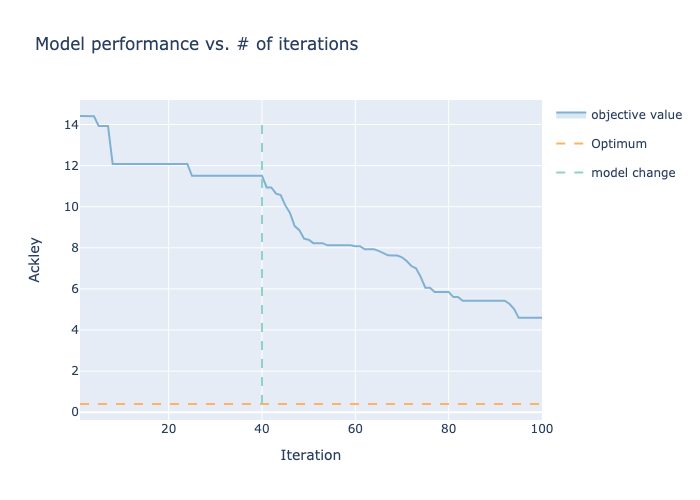

In [59]:
from ax.utils.notebook.plotting import render
render(ax_client.get_optimization_trace(objective_optimum=0.397887))

In [60]:
from botorch.sampling.normal import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]))